# Probabilistic Machine Learning
<div style="text-align: right"> University of Tübingen, Summer Term 2023  &copy; 2023 P. Hennig </div>

## Exercise Sheet No. 2 — Laplace Approximations


---

Submission by:
* Sam, Laing : 6283670
* Albert Catalan Tatjer : 6443478

In [4]:
from io import StringIO

import pandas as pd
import requests

import jax
from jax import numpy as jnp
from jax.scipy import optimize

from matplotlib import pyplot as plt
import matplotlib.tri as tri
from matplotlib import ticker
import numpy as np

from tueplots import bundles
from tueplots.constants.color import rgb


plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({"figure.dpi": 200})


# Exercise 2.2 (Coding Exercise)


In this exercise we are going to practice the Laplace approximation, as well as `jax`. You can use the functionality from `jax` whereever you want to. Your tasks are the following:

**Task 1.** Implement the Beta distribution:

$$ p_z(z) = Beta(z;a,b)$$

You can do it yourself, or use `jax.scipy.stats.beta.pdf`.


In [5]:
from jax.scipy.stats import beta

def p_z(z, a, b):
    """Beta distribution p_z(z).
    
    Args:
      z: Float, Argument of the beta distribution.
      a: Float, Parameter of the beta distribution.
      b: Float, Parameter of the beta distribution.
      
    Returns:
      Value of the probability density function at z.
    """
    # TODO
    return beta.pdf(z,a,b)

In [6]:
# some useful imports for clearer expressions 
from jax.scipy.special import logit
from jax.scipy.special import expit
from jax.numpy import exp

**Task 2.** What is the distribution $p_x(x)$ of $x$ if 

$$ z = logisitc(x) \hspace{1cm} \text{with } \hspace{0.5cm} logistic(x) = 1/(1+exp(-x)?$$

Implement it using the transformation rules from the lecture. `jax.jacrev` might be helpful for calculating Jacobians.

In [30]:
def p_x(x, a, b):
    """Probability density function for x with z=logistic(x). 
    
    Args:
      z: Float, Argument of p_x.
      a: Float, Parameter of the beta distribution of z.
      b: Float, Parameter of the beta distribution of z.
      
    Returns:
      Value of the probability density function p_x(x) at x.
    """
    # TODO
    return p_z(expit(x),a,b) * (expit(x)*(1-expit(x)) )

**Task 3.** Compute the Laplace approximations for both,  $p_z(z)$ and $p_x(x)$.

From slide 33 of lecture 3, we have the Laplace approximation of $p_z(z)$
\
We have to compute $p_x(x)$ by hand using the expression from above 

In [11]:
import scipy.optimize as so

In [105]:
# functions related to Z
def z_hat(a, b):
    return (a - 1) / (a + b - 2)


def psi_z(a, b):
    return -(1 / (a - 1) + 1 / (b - 1)) * (a + b - 2) ** 2


def laplace_z(a, b):
    """Laplace approximation for the beta distribution.

    Args:
      a: Float, Parameter of the beta distribution.
      b: Float, Parameter of the beta distribution.

    Returns:
      A function with the same argument as the beta distribution.
    """

    # TODO
    def l_z(z):
        return p_z(z_hat(a, b), a, b) * exp(0.5 * psi_z(a, b) * (z - z_hat(a, b)) ** 2)

    return l_z


# functions related to X
def x_hat(a, b):
    return logit(a / (a + b))


def psi_x(a, b):
    t = x_hat(a, b)
    return -(a + b) * expit(t) * (1 - expit(t))


def laplace_x(a, b):
    """Laplace approximation for p_x with z=logistic(x).

    Args:
      a: Float, Parameter of the beta distribution.
      b: Float, Parameter of the beta distribution.

    Returns:
      A function with the same argument as p_x.
    """

    # TODO
    def l_x(x):
        return p_x(x_hat(a, b), a, b) * exp(0.5 * psi_x(a, b) * (x - x_hat(a, b)) ** 2)

    return l_x

**Task 4.** Make a plot for $p_z(z)$ and it's Laplace approximation for the parameter combinations $a=2, b=3$ and $a=5, b=5$. Are there parameter combinations, where the Laplace approximation is undefined? Make the same plot for $x$, too.

Plot of $p_z$ with laplace approximation

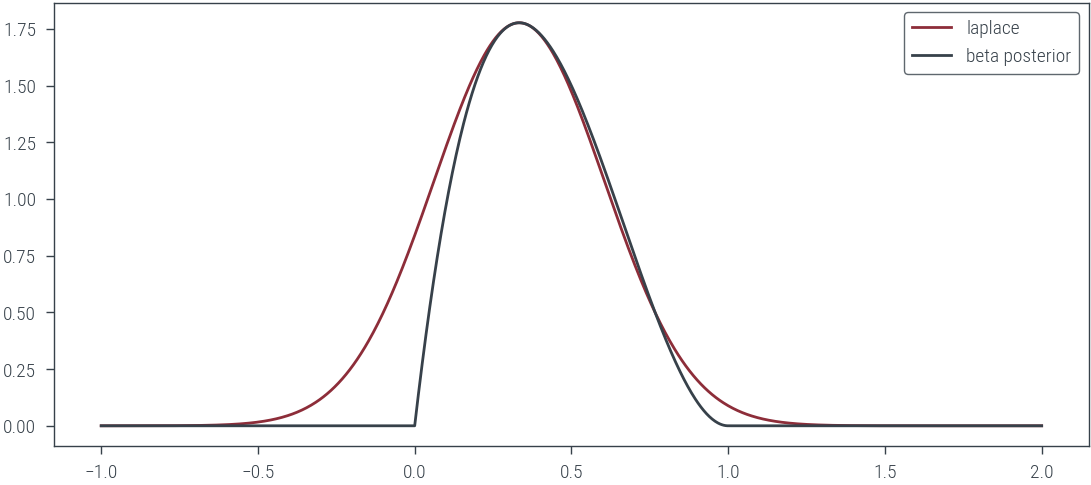

In [107]:
z = np.linspace(-1,2, 1000)
lz = laplace_z(2,3)(z)
pz = p_z(z,2,3)
plt.plot(z,lz, label = "laplace")
plt.plot(z,pz, label = "beta posterior")
plt.legend()
plt.show()

Plot of $p_x$ with laplace approximation 

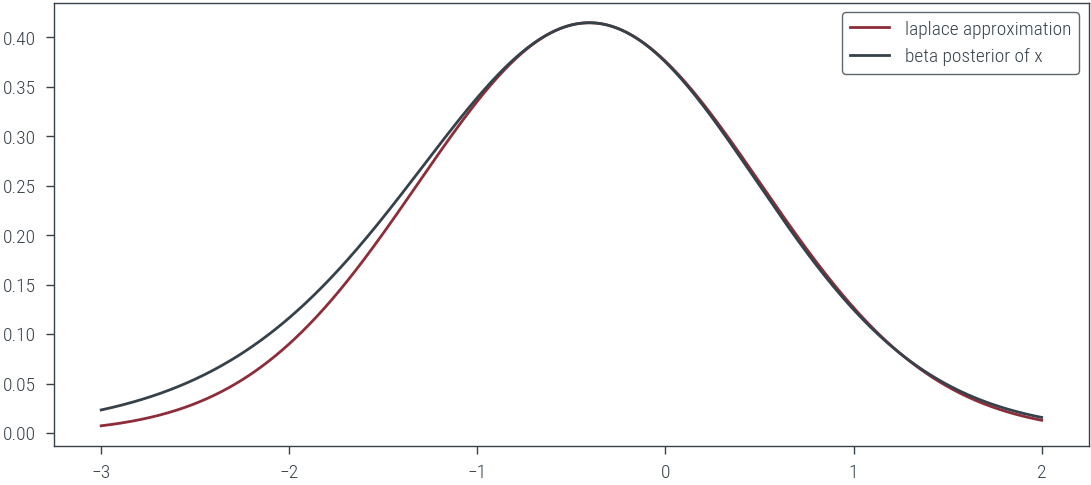

In [108]:
x = np.linspace(-3, 2, 1000)
lx = laplace_x(2, 3)(x)
px = p_x(x, 2, 3)
plt.plot(x, lx, label="laplace approximation")
plt.plot(x, px, label="beta posterior of x")
plt.legend()
plt.show()

**Task 5.** Implement the Dirichlet distribution

$$ p_y(y) = Dirichlet(y; \alpha)$$

(alternative:`jax.scipy.stats.dirichlet.pdf`) and it's Laplace approximation. 

In [20]:
from jax.scipy.stats import dirichlet

In [96]:
def p_y(y, alpha):
    """Dirichlet distribution p_y(y).

    Args:
      y: ArrayLike, Argument of the Dirichlet distribution.
      alpha: ArrayLike, Parameter of the Dirichlet distribution.

    Returns:
      Value of the probability density function at z.
    """
    # TODO
    return dirichlet.pdf(y, alpha)


def laplace_y(alpha):
    """Laplace approximation for the Dirichlet distribution p_y.

    Args:
      alpha: ArrayLike, Parameter of the Dirichlet distribution.

    Returns:
      A function with the same argument as p_y.
    """
    # TODO
    y_hat = alpha / alpha.sum()
    log_differential = -(alpha - 1) / (y_hat**2)

    def l_y(y):
        return p_y(y_hat, alpha) * exp(
            0.5 * (log_differential * (y - y_hat) ** 2).sum()
        )

    return l_y

**Task 6.**
For $\alpha = (2, 10, 2)$ and $\alpha = (3, 2, 5)$, plot $p_y(y)$ and it's Laplace approximation next to each other. The function `simplex_contour_plot` implemented below can help with contour plots over the simplex. You can adapt it in any way you like.

In [93]:
# TODO: Plot
def simplex_contour_plot(fun1, fun2):
    """Make contour plots for two functions, each defined over the probability simplex
       represented by a triangualar surface.

    Args:
      fun1: function, defined over the probability simplex in three dimensions.
      fun2: function, defined over the probability simplex in three dimensions.

    Based on: https://blog.bogatron.net/blog/2014/02/02/visualizing-dirichlet-distributions/
    """

    # Define the triangle
    corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
    area = 0.5 * 1 * 0.75**0.5
    triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=8)

    # For each corner of the triangle, the pair of other corners
    pairs = [corners[np.roll(range(3), -i)[1:]] for i in range(3)]

    # The area of the triangle formed by point xy and another pair or points
    tri_area = lambda xy, pair: 0.5 * np.linalg.norm(np.cross(*(pair - xy)))

    # Convert cartesian to barycentric coordinates
    def xy2bc(xy, tol=1e-6):
        coords = np.array([tri_area(xy, p) for p in pairs]) / area
        return np.clip(coords, tol, 1.0 - tol)

    values1 = [fun1(xy2bc(xy)).item() for xy in zip(trimesh.x, trimesh.y)]
    values2 = [fun2(xy2bc(xy)).item() for xy in zip(trimesh.x, trimesh.y)]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
    axes[0].tricontourf(trimesh, values1)
    axes[1].tricontourf(trimesh, values2)
    axes[0].axis("equal")
    axes[1].axis("equal")
    axes[0].axis("off")
    axes[1].axis("off")
    plt.show()

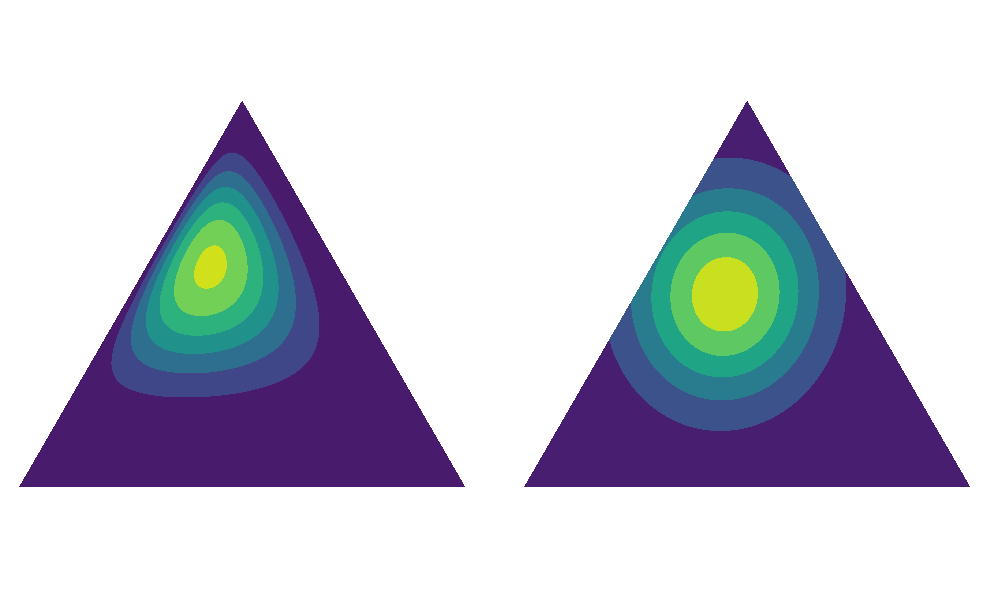

In [94]:
alpha = jax.numpy.array([3, 2, 5])
simplex_contour_plot(lambda y: p_y(y, alpha=alpha), laplace_y(alpha))

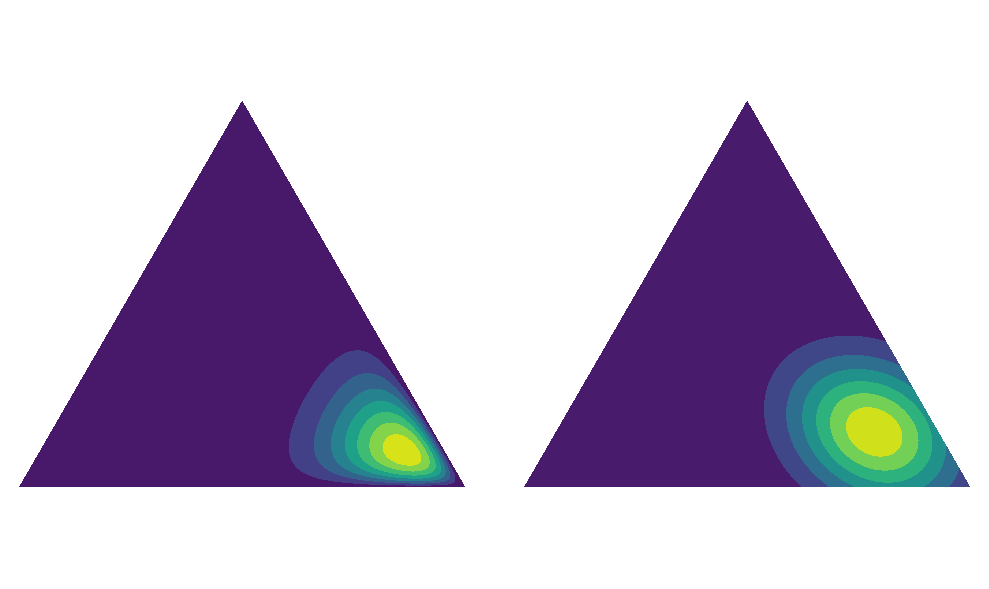

In [95]:
alpha = jax.numpy.array([2, 10, 2])
simplex_contour_plot(lambda y: p_y(y, alpha=alpha), laplace_y(alpha))

### How to submit your work:

Export your answer into a pdf (for example using jupyter's `Save and Export Notebook as` feature in the `File` menu). Make sure to include all outputs, in particular plots. Also include your answer to the theory question, either by adding it as LaTeX code directly in the notebook, or by adding it as an extra page (e.g. a scan) to the pdf. Submit the exercise on Ilias, in the associated folder. **Do not forget to add your name(s) and matricel number(s) above!)**